In [1]:
import numpy as np
import pymc3 as pm
import arviz as az
import astropy
from astropy.table import Table

# This is the notebook where I use the NUTS sampler to get upper limits from the OVRO non-detection and compute the WAIC for different models.

In [2]:
# reference flux
s0=15

In [3]:
dat = Table.read('differential_sky_area.ecsv')

In [4]:
np.sum(dat['sky_area'])

6435758.905828855

In [5]:
9800*659

6458200

In [6]:
dat.columns

<TableColumns names=('detection_threshold','sky_area')>

In [7]:
s= np.append(dat['detection_threshold'], 15)
fov_tot = np.append(dat['sky_area'], 1897*175)
counts = np.zeros_like(s)
counts[-1] = 1

In [8]:
1897*175

331975

In [9]:
s[-1], fov_tot[-1]

(15.0, 331975.0)

In [10]:
counts[-1]

1.0

# Get upper limits from OVRO


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [u, g]
Sampling 4 chains for 5_000 tune and 80_000 draw iterations (20_000 + 320_000 draws total) took 189 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


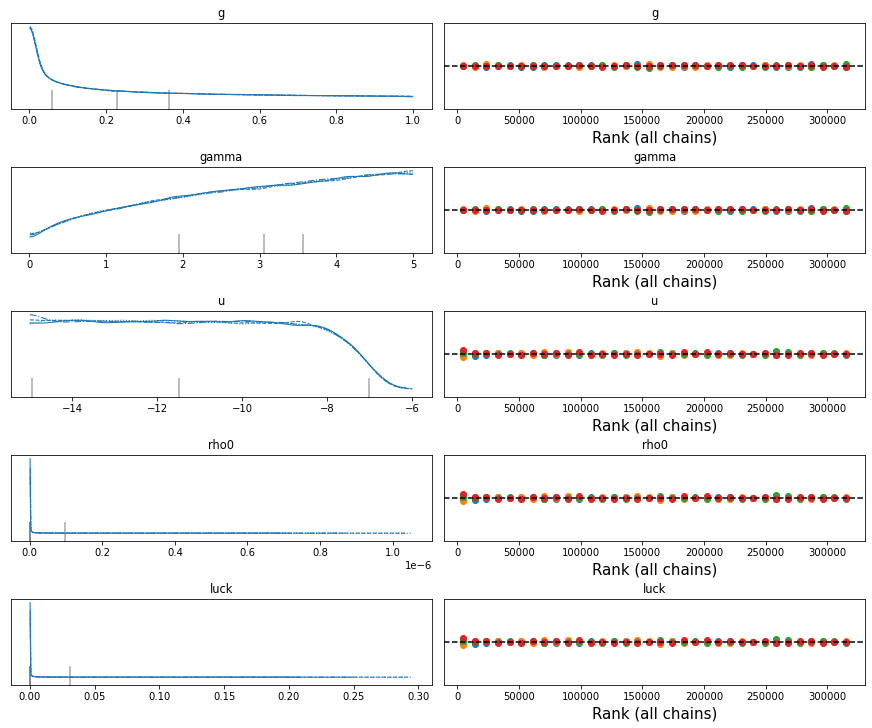

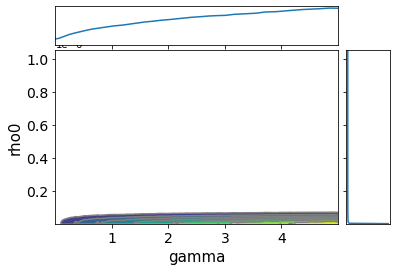

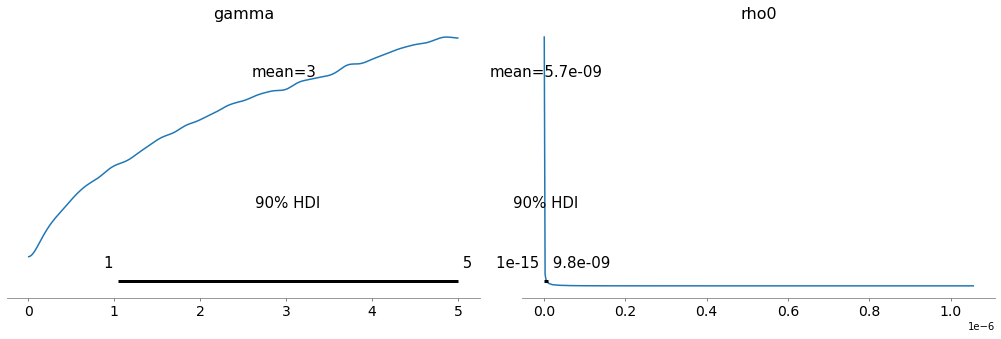

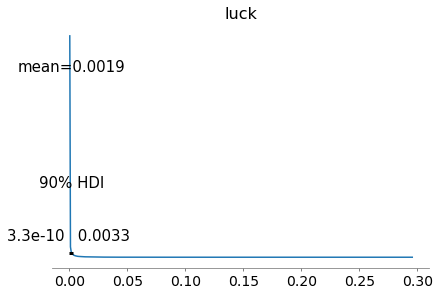

In [11]:
with pm.Model() as m1_ovro1:
    # Transform g to gamma to get gamma \propto gamma^(-3/2)
    # p(g) \propto g^(-1/2), 0<g<1 from Kumaraswamy
    # No bound is set here because it really hampers sampling efficiency; The bounds don't affect the marginalized posteriors anyway 
    g = pm.Kumaraswamy('g', a=0.5, b=1, testval=0.5)
    gamma = pm.Deterministic('gamma', 5*(g**(1/3)))
    # transform a uniform to rho0 such that p(rho0) \propto 1/rho0
    u = pm.Uniform('u', lower=-15, upper=0, testval=-9)
    rho0 = pm.Deterministic('rho0', 10**(u))
    luck = pm.Deterministic('luck', 1-pm.math.exp(-rho0*fov_tot[-1]))
    pm.Poisson("n", mu=rho0*((s[:-1]/s0)**(-gamma))*fov_tot[:-1], observed=counts[:-1])
    t_m1_lwa = pm.sample(tune=5000, draws=80000, chains=4, target_accept=0.99, return_inferencedata=True, progressbar=False)
    az.plot_trace(t_m1_lwa, kind="rank_vlines")
    az.plot_pair(t_m1_lwa, marginals=True, var_names=['gamma', 'rho0'], kind='kde', kde_kwargs={'contour':True})
    axs = az.plot_posterior(t_m1_lwa, var_names=['gamma', 'rho0'], hdi_prob=0.9)
    axs = az.plot_posterior(t_m1_lwa, var_names=['luck'], hdi_prob=0.9)

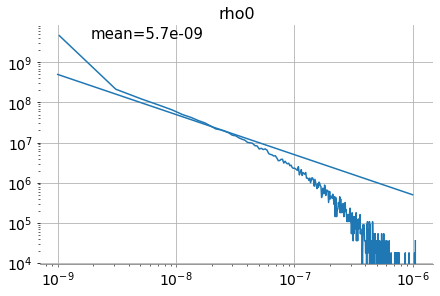

In [12]:
a = az.plot_posterior(t_m1_lwa, var_names=['rho0'], hdi_prob='hide')
a.plot([1e-9, 1e-6], [0.5e9, 0.5e6])
a.set_xscale('log')
a.set_yscale('log')
a.grid(True)

Use quantile to compute the upper limits

In [13]:
t_m1_lwa['posterior']['rho0'].quantile(0.95)

<xarray.DataArray 'rho0' ()>
array(2.97965925e-08)
Coordinates:
    quantile  float64 0.95

In [14]:
t_m1_lwa['posterior']['rho0'].quantile(0.997)

<xarray.DataArray 'rho0' ()>
array(2.0882391e-07)
Coordinates:
    quantile  float64 0.997

In [15]:
az.summary(t_m1_lwa)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
g,0.328,0.297,0.000,0.880,0.001,0.001,110883.0,85898.0,1.0
gamma,2.971,1.316,0.737,5.000,0.004,0.003,110883.0,85898.0,1.0
u,-11.131,2.269,-14.999,-7.630,0.009,0.007,56045.0,57116.0,1.0
rho0,0.000,0.000,0.000,0.000,0.000,0.000,56045.0,57116.0,1.0
luck,0.002,0.008,0.000,0.008,0.000,0.000,56045.0,57116.0,1.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho0, gamma]
Sampling 4 chains for 5_000 tune and 40_000 draw iterations (20_000 + 160_000 draws total) took 31 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


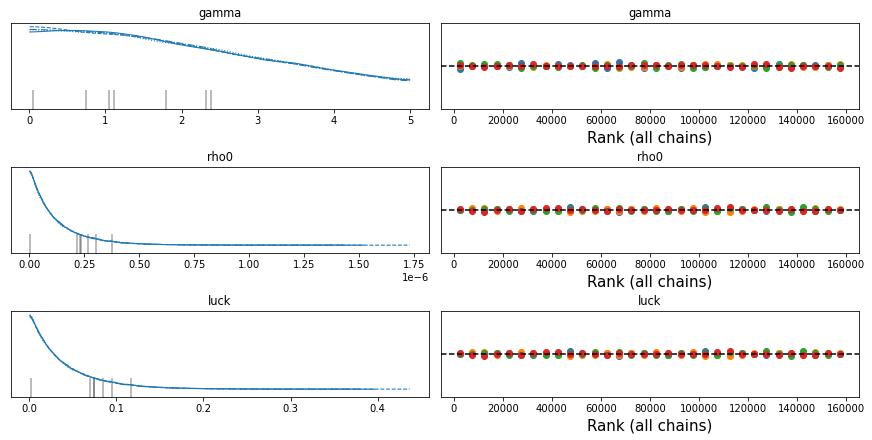

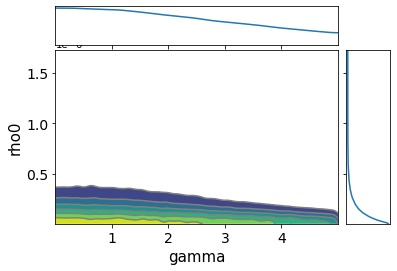

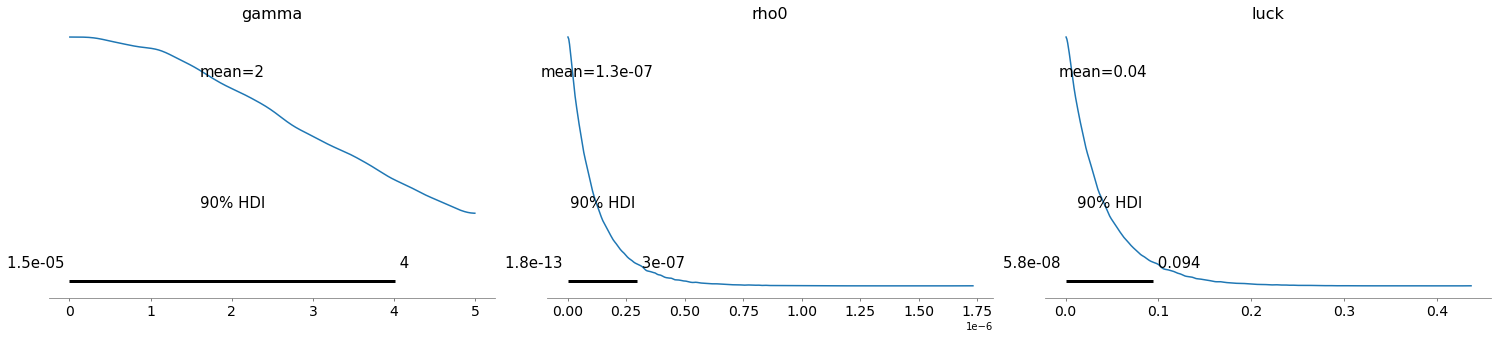

In [16]:
with pm.Model() as m1_ovro2:
    gamma = pm.Uniform('gamma', lower=0, upper=5)
    rho0 = pm.HalfFlat('rho0')
    luck = pm.Deterministic('luck', 1-pm.math.exp(-rho0*fov_tot[-1]))
    pm.Poisson("n", mu=rho0*((s[:-1]/s0)**(-gamma))*fov_tot[:-1], observed=counts[:-1])
    trace_m1_2 = pm.sample(tune=5000, draws=40000, chains=4, target_accept=0.88, return_inferencedata=True, progressbar=False)
    az.plot_trace(trace_m1_2, kind="rank_vlines")
    az.plot_pair(trace_m1_2, marginals=True, var_names=['gamma', 'rho0'], kind='kde', kde_kwargs={'contour':True})
    axs = az.plot_posterior(trace_m1_2, var_names=['gamma', 'rho0', 'luck'], hdi_prob=0.9)

In [17]:
trace_m1_2['posterior']['rho0'].quantile(0.95)

<xarray.DataArray 'rho0' ()>
array(3.92331172e-07)
Coordinates:
    quantile  float64 0.95

In [18]:
trace_m1_2['posterior']['rho0'].quantile(0.997)

<xarray.DataArray 'rho0' ()>
array(8.06386055e-07)
Coordinates:
    quantile  float64 0.997

The effective sample size for the uninformative prior looked decent (18%) for the uninformative prior so this should be fine.

# Inference with both OVRO and MSSS data under a single rate model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [u, g]
Sampling 4 chains for 5_000 tune and 40_000 draw iterations (20_000 + 160_000 draws total) took 40 seconds.


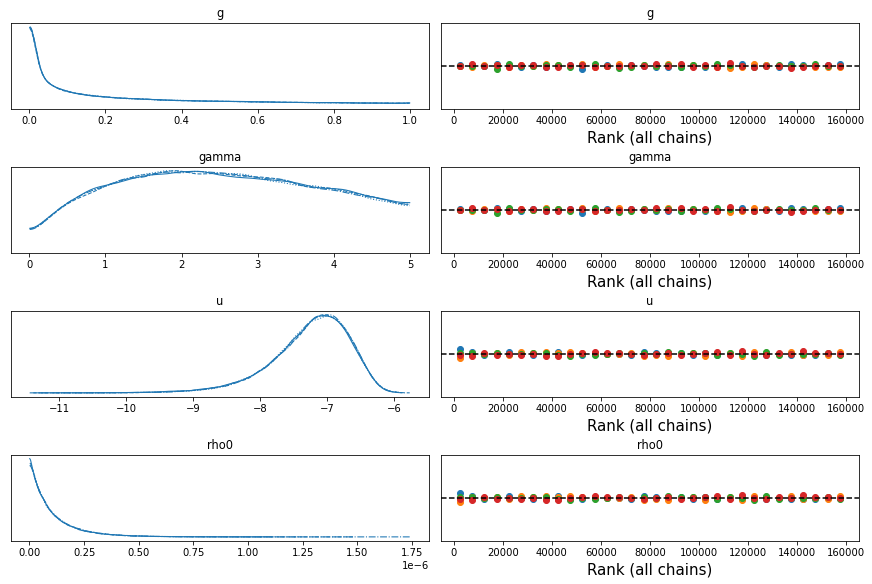

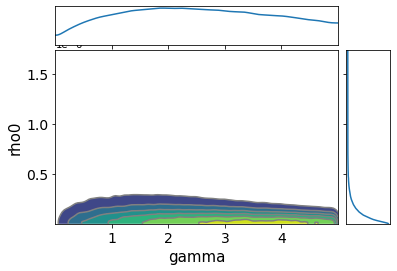

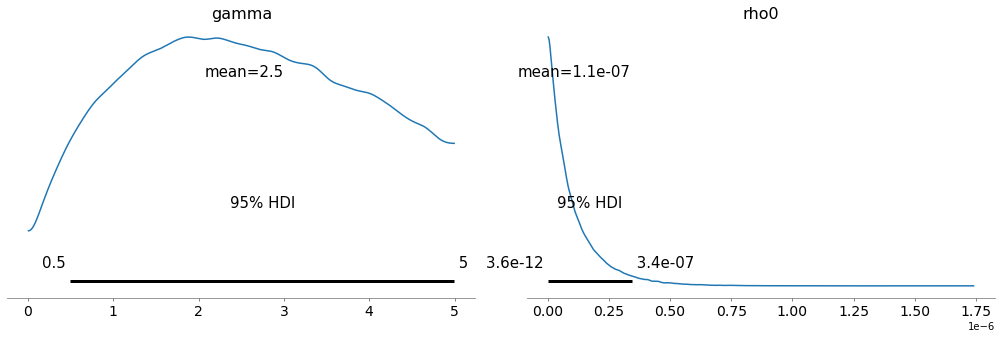

In [19]:
with pm.Model() as m1_both: 
    g = pm.Kumaraswamy('g', a=0.5, b=1, testval=0.5)
    gamma = pm.Deterministic('gamma', 5*(g**(1/3)))
    # transform a uniform to rho0 such that p(rho0) \propto 1/rho0
    u = pm.Uniform('u', lower=-15, upper=0, testval=-9)
    rho0 = pm.Deterministic('rho0', 10**(u))
    pm.Poisson("n", mu=rho0*((s/s0)**(-gamma))*fov_tot, observed=counts)
    trace_m1_both = pm.sample(tune=5000, draws=40000, chains=4, target_accept=0.9, return_inferencedata=True, progressbar=False)
    az.plot_trace(trace_m1_both, kind="rank_vlines")
    az.plot_pair(trace_m1_both, var_names=['gamma', 'rho0'], marginals=True, kind='kde', kde_kwargs={'contour':True})
    axs = az.plot_posterior(trace_m1_both, var_names=['gamma', 'rho0'], hdi_prob=0.95)

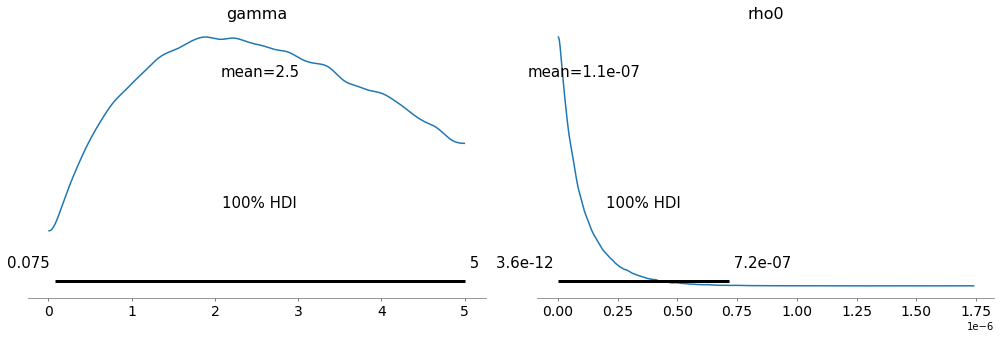

In [20]:
with m1_both:
    axs = az.plot_posterior(trace_m1_both, var_names=['gamma', 'rho0'], hdi_prob=0.997)

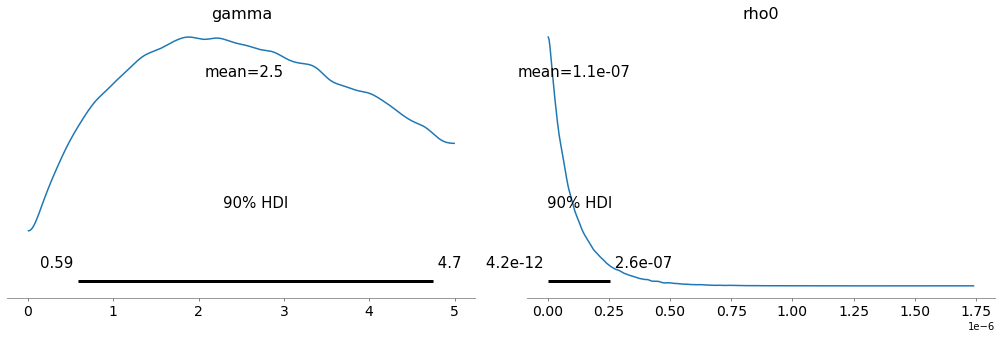

In [21]:
with m1_both:
    axs = az.plot_posterior(trace_m1_both, var_names=['gamma', 'rho0'], hdi_prob=0.90)

# The two-rate model and WAIC calculations for different priors on r

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ur, u, g]
Sampling 4 chains for 5_000 tune and 40_000 draw iterations (20_000 + 160_000 draws total) took 53 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


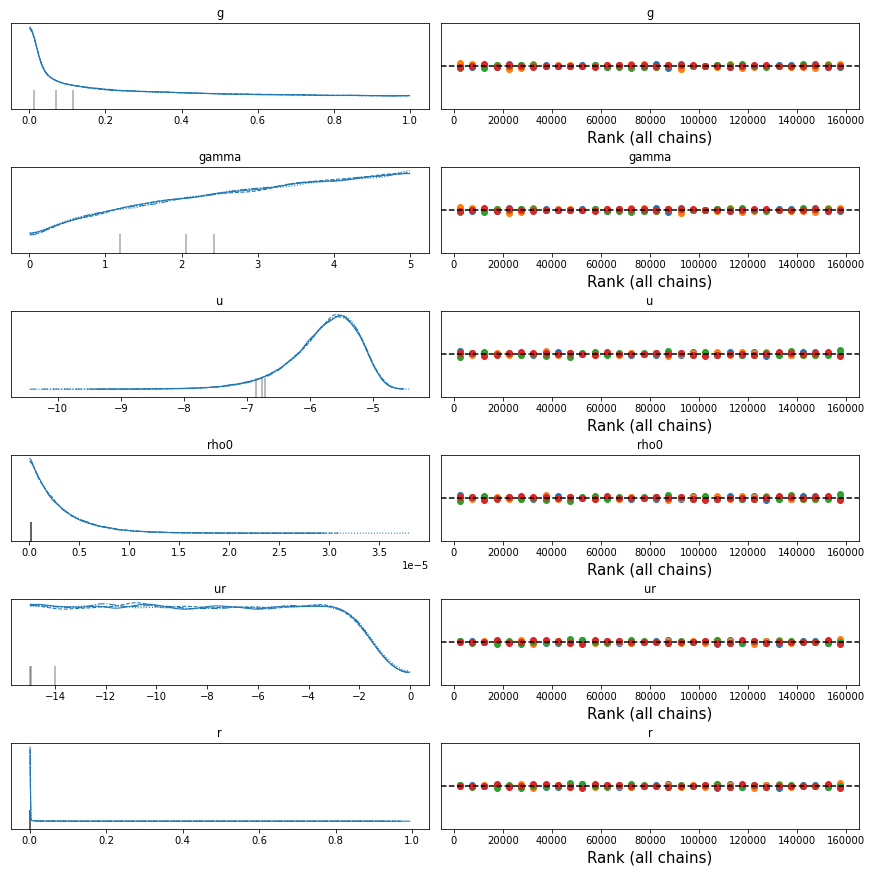

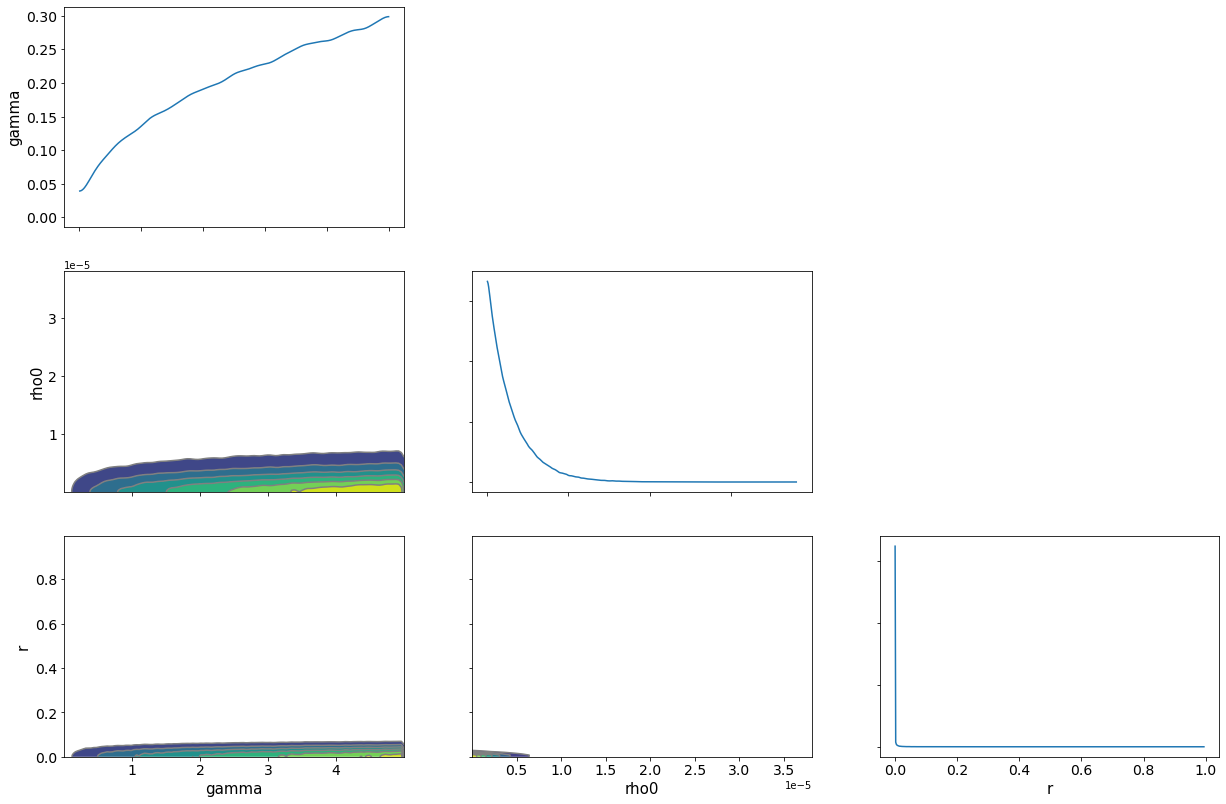

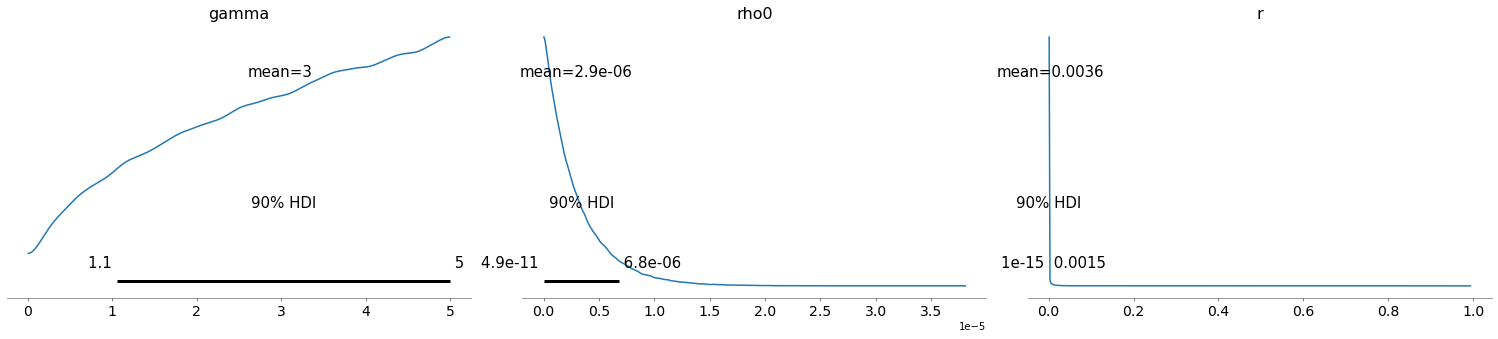

In [22]:
with pm.Model() as m2_both: 
    g = pm.Kumaraswamy('g', a=0.5, b=1, testval=0.5)
    gamma = pm.Deterministic('gamma', 5*(g**(1/3)))
    # transform a uniform to rho0 such that p(rho0) \propto 1/rho0
    u = pm.Uniform('u', lower=-15, upper=0, testval=-9)
    rho0 = pm.Deterministic('rho0', 10**(u))
    ur = pm.Uniform('ur', lower=-15, upper=0, testval=-3)
    r = pm.Deterministic('r', 10**(ur))
    is_ovro = np.ones_like(s, dtype=int)
    is_ovro[-1] = 0
    pm.Poisson("n",
               mu=(1 * (1-is_ovro) + (is_ovro)*r)*rho0*((s/s0)**(-gamma))*fov_tot,
               observed=counts
              )
    trace_m2_both = pm.sample(tune=5000, draws=40000, chains=4, target_accept=0.94, return_inferencedata=True, progressbar=False)
    az.plot_trace(trace_m2_both, kind="rank_vlines")
    az.plot_pair(trace_m2_both, var_names=['gamma', 'rho0', 'r'], marginals=True, kind='kde', kde_kwargs={'contour':True})
    axs = az.plot_posterior(trace_m2_both, var_names=['gamma', 'rho0', 'r'], hdi_prob=0.9)

In [23]:
az.compare({'m1': trace_m1_both, 'm2': trace_m2_both}, ic='waic')

/home/yuping/.conda/envs/pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/yuping/.conda/envs/pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/yuping/.conda/envs/pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m2,0,-2.077598,0.653640,0.000000,1.000000e+00,2.043092,0.000000,True,log
m1,1,-6.106185,1.723277,4.028588,1.776357e-15,5.115800,3.073062,True,log


In [24]:
np.exp(4.032037)

56.37563152627448

# Now run the same thing with two other priors on r.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r, u, g]
Sampling 4 chains for 5_000 tune and 40_000 draw iterations (20_000 + 160_000 draws total) took 57 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


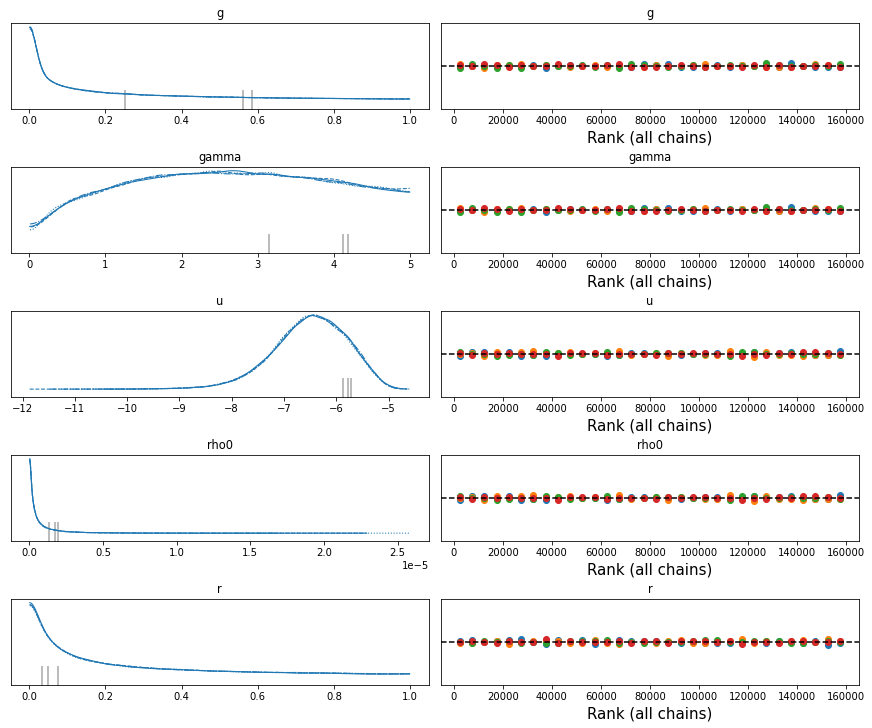

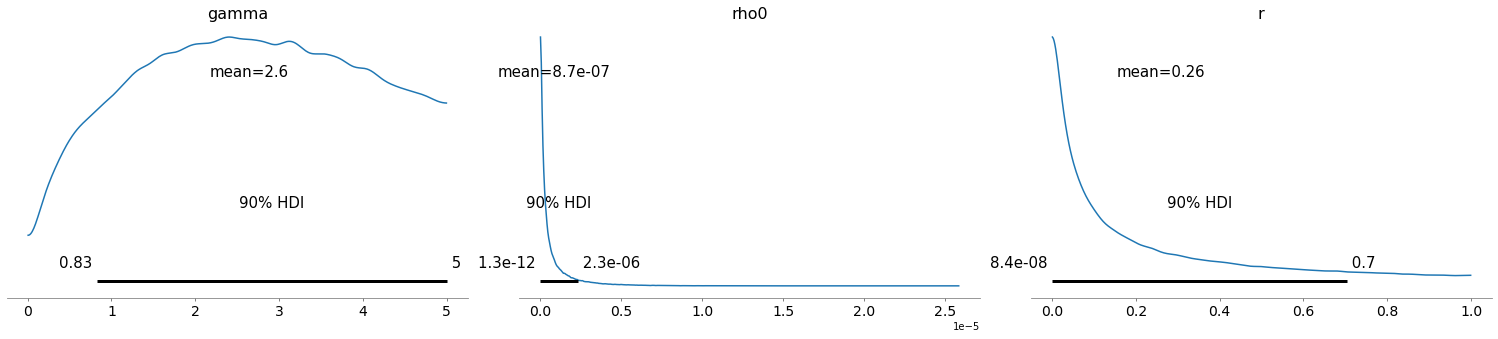

In [25]:
with pm.Model() as m2_both_unif: 
    g = pm.Kumaraswamy('g', a=0.5, b=1, testval=0.5)
    gamma = pm.Deterministic('gamma', 5*(g**(1/3)))
    # transform a uniform to rho0 such that p(rho0) \propto 1/rho0
    u = pm.Uniform('u', lower=-15, upper=0, testval=-9)
    rho0 = pm.Deterministic('rho0', 10**(u))
    r = pm.Uniform('r', lower=0, upper=1)
    is_ovro = np.ones_like(s, dtype=int)
    is_ovro[-1] = 0
    pm.Poisson("n",
               mu=(1 * (1-is_ovro) + (is_ovro)*r)*rho0*((s/s0)**(-gamma))*fov_tot,
               observed=counts
              )
    trace_m2_both_unif = pm.sample(tune=5000, draws=40000, chains=4, target_accept=0.92, return_inferencedata=True, progressbar=False)
    az.plot_trace(trace_m2_both_unif, kind="rank_vlines")
    # az.plot_pair(trace_m2_both_unif, var_names=['gamma', 'rho0', 'r'], marginals=True, kind='kde', kde_kwargs={'contour':True})
    axs = az.plot_posterior(trace_m2_both_unif, var_names=['gamma', 'rho0', 'r'], hdi_prob=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1/r, u, g]
Sampling 4 chains for 5_000 tune and 40_000 draw iterations (20_000 + 160_000 draws total) took 45 seconds.


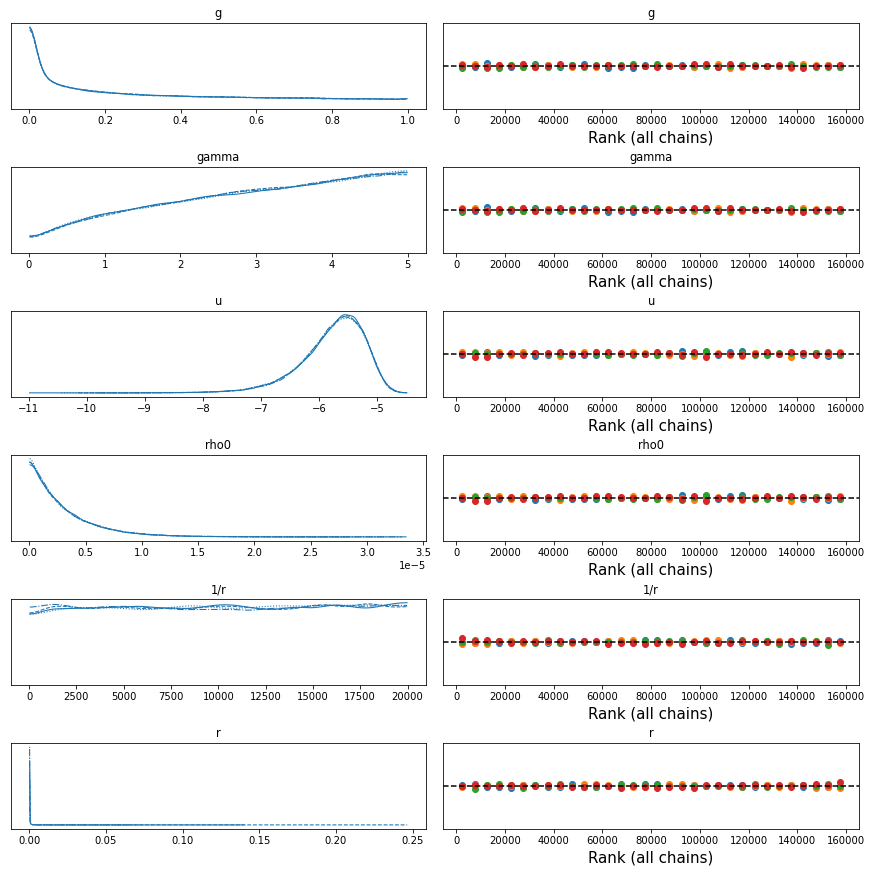

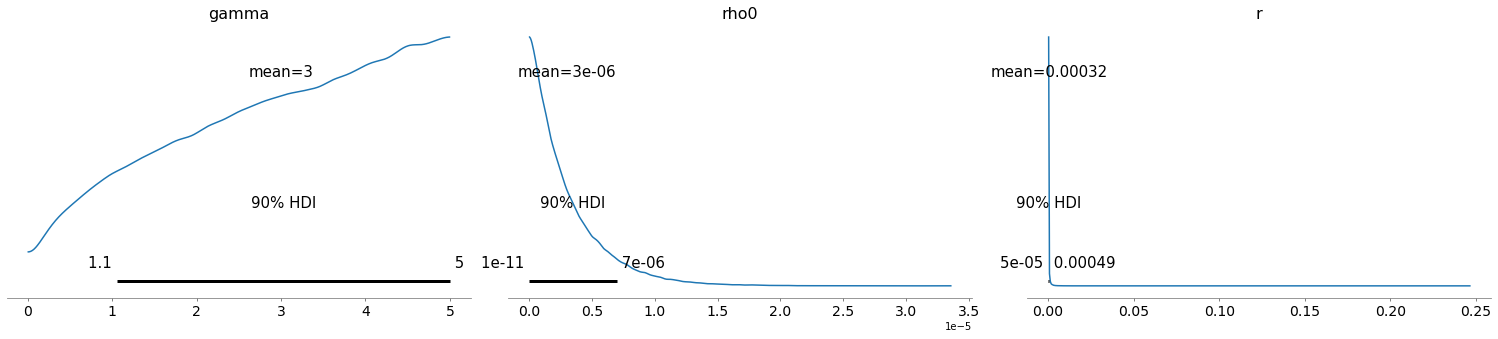

In [26]:
with pm.Model() as m2_both_1_over: 
    g = pm.Kumaraswamy('g', a=0.5, b=1, testval=0.5)
    gamma = pm.Deterministic('gamma', 5*(g**(1/3)))
    # transform a uniform to rho0 such that p(rho0) \propto 1/rho0
    u = pm.Uniform('u', lower=-15, upper=0, testval=-9)
    rho0 = pm.Deterministic('rho0', 10**(u))
    one_over_r = pm.Uniform('1/r', lower=1, upper=2e4)
    r = pm.Deterministic('r', 1/one_over_r)
    is_ovro = np.ones_like(s, dtype=int)
    is_ovro[-1] = 0
    pm.Poisson("n",
               mu=(1 * (1-is_ovro) + (is_ovro)*r)*rho0*((s/s0)**(-gamma))*fov_tot,
               observed=counts
              )
    trace_m2_both_1_over = pm.sample(tune=5000, draws=40000, chains=4, target_accept=0.9, return_inferencedata=True, progressbar=False)
    az.plot_trace(trace_m2_both_1_over, kind="rank_vlines")
    # az.plot_pair(trace_m2_both_1_over, var_names=['gamma', 'rho0', 'r'], marginals=True, kind='kde', kde_kwargs={'contour':True})
    axs = az.plot_posterior(trace_m2_both_1_over, var_names=['gamma', 'rho0', 'r'], hdi_prob=0.9)

In [27]:
az.compare({'m1': trace_m1_both, 'm2_1_over':trace_m2_both_1_over}, ic='waic')

/home/yuping/.conda/envs/pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/yuping/.conda/envs/pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/yuping/.conda/envs/pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m2_1_over,0,-2.039621,0.642006,0.000000,1.0,2.027685,0.000000,True,log
m1,1,-6.106185,1.723277,4.066565,0.0,5.115800,3.088511,True,log


In [28]:
az.compare({'m1': trace_m1_both, 'm2_unif': trace_m2_both_unif}, ic='waic')

/home/yuping/.conda/envs/pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/yuping/.conda/envs/pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/yuping/.conda/envs/pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m2_unif,0,-4.549959,1.851501,0.000000,1.000000e+00,3.81578,0.000000,True,log
m1,1,-6.106185,1.723277,1.556226,1.110223e-16,5.11580,1.300022,True,log


In [29]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Sep 13 2021

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 7.25.0

astropy: 4.2.1
arviz  : 0.11.2
pymc3  : 3.11.2
numpy  : 1.21.0

Watermark: 2.2.0

